In [62]:
from SQL import SQL_TabellenLadenBearbeiten as sql
import pandas as pd
import numpy as np
import parquet as pq
import pyarrow as pa
import plotly.express as px

In [63]:
df = pd.read_parquet('df.parquet.gzip')


In [64]:
dflt22 = pd.read_parquet('/Users/martinwolf/Python/Superdepot Reporting/Data/upload/lt22.parquet')


In [65]:
#filter dflt22['Pick Datum'] by date
#dflt22 = dflt22[dflt22['Pick Datum'] == '2023-01-12']
#filtter df by date
df = df[df['PlannedDate'] == '2023-01-12']


Python Füge zu df.ErsterPickDate den größten wert aus dflt22.PickZeit hinzu wenn in df.SapOrderNumber der wert aus dflt22.DestBin vorkommt

In [66]:
df['ErsterPickTime'] = df.apply(lambda x: dflt22[dflt22['DestBin'] == x['SapOrderNumber']]['Pick Zeit'].max(), axis=1)
df['LetzterPickTime'] = df.apply(lambda x: dflt22[dflt22['DestBin'] == x['SapOrderNumber']]['Pick Zeit'].min(), axis=1)
df['PickDauer'] = df.apply(lambda x: x['ErsterPickTime'] - x['LetzterPickTime'], axis=1)
df['PickDauer'] = df['PickDauer'].dt.total_seconds()
#in minutes
def calculate_duration(row):
    start_time = row['LetzterPickTime']
    end_time = row['ErsterPickTime']
    duration = end_time - start_time
    if end_time.hour < 6:
        duration += pd.Timedelta(days=1)
    if start_time.hour >= 22:
        duration += pd.Timedelta(days=1)
    return duration.total_seconds() / 60.

df['PickDauer'] = df.apply(calculate_duration, axis=1)
#round to 2 decimals
df['PickDauer'] = df['PickDauer'].round()


df.head()

,PlannedDate,PartnerName,SapOrderNumber,AllSSCCLabelsPrinted,DeliveryDepot,Picks Gesamt,Lieferschein erhalten,Fertiggestellt,Truck Kennzeichen,Picks Karton,...,Picks Karton offen,Picks Paletten offen,Picks Stangen offen,Picks Karton fertig,Picks Paletten fertig,Picks Stangen fertig,Fertige Paletten,ErsterPickTime,LetzterPickTime,PickDauer
7990,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194431,True,KNSTR,110,2023-01-12 08:07:32.201128+00:00,2023-01-12 11:58:52.479480+00:00,20230112_BT ST 9359,59.0,...,0.0,0.0,0.0,59.0,0.0,51.0,0,1900-01-01 12:09:37,1900-01-01 09:29:32,160.0
7991,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194435,False,KNSTR,0,2023-01-12 09:07:20.241989+00:00,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaT,NaT,NaN
7992,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256165,True,KNSTR,57,2023-01-12 07:52:12.664803+00:00,2023-01-12 09:45:01.449564+00:00,20230112_BT ST 9341,56.0,...,0.0,0.0,0.0,56.0,0.0,1.0,0,1900-01-01 10:41:22,1900-01-01 09:37:28,64.0
7993,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256166,True,KNSTR,1,2023-01-12 07:52:18.994306+00:00,2023-01-12 08:41:58.722367+00:00,20230112_BT ST 9359,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1900-01-01 09:39:40,1900-01-01 09:39:40,0.0
7994,2023-01-12 00:00:00+00:00,Dietz GmbH,3202284420,False,KNSTR,0,2023-01-12 08:43:23.875271+00:00,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaT,NaT,NaN


In [67]:
#add Pick Date to df
df['LetzterPickDate'] = df.apply(lambda x: dflt22[dflt22['DestBin'] == x['SapOrderNumber']]['Pick Datum'].max(), axis=1)
df['ErsterPickDate'] = df.apply(lambda x: dflt22[dflt22['DestBin'] == x['SapOrderNumber']]['Pick Datum'].min(), axis=1)
df.head()


,PlannedDate,PartnerName,SapOrderNumber,AllSSCCLabelsPrinted,DeliveryDepot,Picks Gesamt,Lieferschein erhalten,Fertiggestellt,Truck Kennzeichen,Picks Karton,...,Picks Stangen offen,Picks Karton fertig,Picks Paletten fertig,Picks Stangen fertig,Fertige Paletten,ErsterPickTime,LetzterPickTime,PickDauer,LetzterPickDate,ErsterPickDate
7990,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194431,True,KNSTR,110,2023-01-12 08:07:32.201128+00:00,2023-01-12 11:58:52.479480+00:00,20230112_BT ST 9359,59.0,...,0.0,59.0,0.0,51.0,0,1900-01-01 12:09:37,1900-01-01 09:29:32,160.0,01/12/23,01/12/23
7991,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194435,False,KNSTR,0,2023-01-12 09:07:20.241989+00:00,0,0,0.0,...,0.0,0.0,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN
7992,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256165,True,KNSTR,57,2023-01-12 07:52:12.664803+00:00,2023-01-12 09:45:01.449564+00:00,20230112_BT ST 9341,56.0,...,0.0,56.0,0.0,1.0,0,1900-01-01 10:41:22,1900-01-01 09:37:28,64.0,01/12/23,01/12/23
7993,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256166,True,KNSTR,1,2023-01-12 07:52:18.994306+00:00,2023-01-12 08:41:58.722367+00:00,20230112_BT ST 9359,1.0,...,0.0,1.0,0.0,0.0,0,1900-01-01 09:39:40,1900-01-01 09:39:40,0.0,01/12/23,01/12/23
7994,2023-01-12 00:00:00+00:00,Dietz GmbH,3202284420,False,KNSTR,0,2023-01-12 08:43:23.875271+00:00,0,0,0.0,...,0.0,0.0,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN


In [68]:
def calculate_picks_per_minute(row):
    if row['Picks Gesamt'] == 0:
        return 0
    else:
        return row['PickDauer'] / row['Picks Gesamt']

df['PicksProMinute'] = df.apply(calculate_picks_per_minute, axis=1)
df['PicksProMinute'] = df['PicksProMinute'].round()

def calculate_picks_per_stunde(row):
    if row['Picks Gesamt'] == 0:
        return 0
    else:
        return (row['PickDauer']*60) / row['Picks Gesamt']

df['PicksProStunde'] = df.apply(calculate_picks_per_stunde, axis=1)
df['PicksProStunde'] = df['PicksProStunde'].round()
df.head()

,PlannedDate,PartnerName,SapOrderNumber,AllSSCCLabelsPrinted,DeliveryDepot,Picks Gesamt,Lieferschein erhalten,Fertiggestellt,Truck Kennzeichen,Picks Karton,...,Picks Paletten fertig,Picks Stangen fertig,Fertige Paletten,ErsterPickTime,LetzterPickTime,PickDauer,LetzterPickDate,ErsterPickDate,PicksProMinute,PicksProStunde
7990,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194431,True,KNSTR,110,2023-01-12 08:07:32.201128+00:00,2023-01-12 11:58:52.479480+00:00,20230112_BT ST 9359,59.0,...,0.0,51.0,0,1900-01-01 12:09:37,1900-01-01 09:29:32,160.0,01/12/23,01/12/23,1.0,87.0
7991,2023-01-12 00:00:00+00:00,Dietz GmbH,3202194435,False,KNSTR,0,2023-01-12 09:07:20.241989+00:00,0,0,0.0,...,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,0.0,0.0
7992,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256165,True,KNSTR,57,2023-01-12 07:52:12.664803+00:00,2023-01-12 09:45:01.449564+00:00,20230112_BT ST 9341,56.0,...,0.0,1.0,0,1900-01-01 10:41:22,1900-01-01 09:37:28,64.0,01/12/23,01/12/23,1.0,67.0
7993,2023-01-12 00:00:00+00:00,Dietz GmbH,3202256166,True,KNSTR,1,2023-01-12 07:52:18.994306+00:00,2023-01-12 08:41:58.722367+00:00,20230112_BT ST 9359,1.0,...,0.0,0.0,0,1900-01-01 09:39:40,1900-01-01 09:39:40,0.0,01/12/23,01/12/23,0.0,0.0
7994,2023-01-12 00:00:00+00:00,Dietz GmbH,3202284420,False,KNSTR,0,2023-01-12 08:43:23.875271+00:00,0,0,0.0,...,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,0.0,0.0


<AxesSubplot:xlabel='SapOrderNumber'>

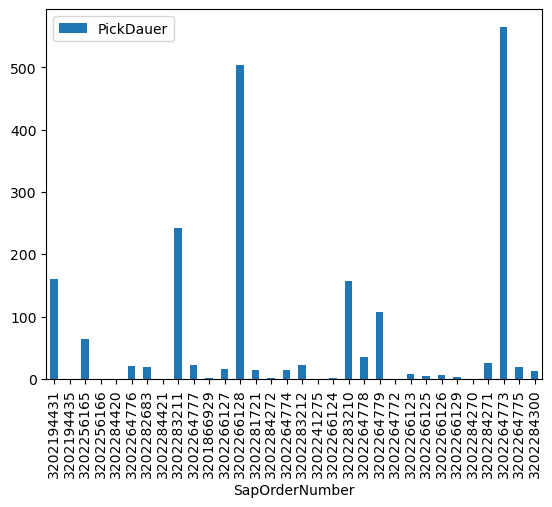

In [69]:
#plot PickDauer by SapOrderNumber
df.plot(x='SapOrderNumber', y='PickDauer', kind='bar')